# MAHTS testing

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 
    
***


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [41]:
%matplotlib inline

import os
import sys
import otps
import datacube
import shapely.wkt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import measure
from skimage.morphology import disk
from skimage.morphology import square
from skimage.morphology import binary_dilation
from datacube.helpers import write_geotiff
from datacube.virtual import catalog_from_file

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_spatialtools import interpolate_2d
from dea_plotting import display_map
from dea_spatialtools import contour_extract
from dea_plotting import map_shapefile


def largest_region(bool_array, **kwargs):
    
    '''
    Takes a boolean array and identifies the largest contiguous region of 
    connected True values. This is returned as a new array with cells in 
    the largest region marked as True, and all other cells marked as False.
    
    Parameters
    ----------  
    bool_array : boolean array
        A boolean array (numpy or xarray DataArray) with True values for
        the areas that will be inspected to find the largest group of 
        connected cells
    **kwargs : 
        Optional keyword arguments to pass to `measure.label`
        
    Returns
    -------
    largest_region : boolean array
        A boolean array with cells in the largest region marked as True, 
        and all other cells marked as False.       
        
    '''
    
    # First, break boolean array into unique, descrete regions/blobs
    blobs_labels = measure.label(bool_array, background=0, **kwargs)
    
    # Count the size of each blob, excluding the background class (0)
    ids, counts = np.unique(blobs_labels[blobs_labels > 0], 
                            return_counts=True) 
    
    # Identify the region ID of the largest blob
    largest_region_id = ids[np.argmax(counts)]
    
    # Produce a boolean array where 1 == the largest region
    largest_region = blobs_labels == largest_region_id
    
    return largest_region


def interpolate_tide(timestep_ds, tidepoints_gdf, sigma=20):    
    '''
    Extract a subset of tide modelling point data for a given time-step,
    then interpolate these tides into the extent of the xarray dataset.
    '''
    
    # Extract subset of observations based on timestamp of imagery
    time_string = str(timestep_ds.time.values)[0:10]
    tidepoints_subset = tidepoints_gdf.loc[time_string]
    
    # Get lists of x, y and z (tide height) data to interpolate
    x_coords = tidepoints_subset.geometry.x,
    y_coords = tidepoints_subset.geometry.y,
    z_coords = tidepoints_subset.tide_m
    
    # Interpolate tides into the extent of the satellite timestep
    out_tide = interpolate_2d(ds=timestep_ds,
                              x_coords=x_coords,
                              y_coords=y_coords,
                              z_coords=z_coords,
                              fill_nearest=True,
                              sigma=sigma)
    
    # Return data as a Float32 to conserve memory
    return out_tide.astype(np.float32)


def hightide_composite(year_ds, tide_cutoff, output_dir):
    '''
    Loads data for a time period into memory, masks to keep only
    > median tide pixels, takes median and counts of valid water
    index results, and writes each water index, tide height and valid
    pixel counts for the time period to file
    '''
    
    # Print status
    year = year_ds.time[0].dt.year.item()
    print(f'Processing {year}')
    
    # Load in data for year and mask to keep above median tide pixels
    year_ds = year_ds.compute()
    year_ds = year_ds.where(year_ds.tide_m >= tide_cutoff)
    
    # Compute median water indices and counts of valid pixels
    median_ds = year_ds.median(dim='time', keep_attrs=True)
    median_ds['count'] = (year_ds.mndwi
                          .count(dim='time', keep_attrs=True)
                          .astype('int16'))
    
    # Write each variable to file
    for i in median_ds:
        write_geotiff(filename=f'{output_dir}/{i}_{str(year)}.tif', 
                      dataset=median_ds[[i]])
        
    return median_ds


def mask_ocean(bool_array, **kwargs):
    '''
    Identifies ocean by selecting the largest connected area of water
    pixels, then dilating this region by 1 pixel to include mixed pixels
    '''
    
    ocean_mask = largest_region(bool_array, **kwargs)
    ocean_mask = binary_dilation(ocean_mask, 
                                 selem=square(3))

    return ocean_mask



# This will speed up loading data
import datacube.utils.rio
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)


### Connect to the datacube

In [3]:
# dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')
dc = datacube.Datacube(app='MAHTS_testing')

### Load virtual products catalogue


In [4]:
catalog = catalog_from_file('MAHTS_virtual_products.yaml')

### Load tidal points


In [5]:
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')

In [6]:
# # Gold Coast
# name = 'goldcoast'
# query = {'x': (153.49,  153.68),
#          'y': (-28.08, -28.2681),
#          'time': ('2000', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}


# # Moreton Bay
# name = 'moretonbay'
# query = {'x': (153.00, 153.25),
#          'y': (-26.81, -27.44),
#          'time': ('2008', '2008'),
#          'cloud_cover': [0, 80]}

# # Moreton Bay seam test
# name = 'moretonbay'
# query = {'x': (153.10, 153.18),
#          'y': (-26.70, -26.83),
#          'time': ('2000', '2010'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# # Moreton Bay small
# name = 'moretonbay'
# query = {'x': (153.16, 153.2840),
#          'y': (-27.315, -27.4416),
#          'time': ('2000', '2010'),
# #          'output_crs': 'EPSG:32756',
# #          'resolution': (-30, 30),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# Fremantle
name = 'fremantle'
query = {'x': (115.699173,  115.811948),
         'y': (-31.941483, -32.079094),
         'time': ('2015', '2018'),
         'dask_chunks': {'time': 1},
         'cloud_cover': [0, 80]}


# Preview study area
display_map(x=query['x'], y=query['y'])

## Load virtual product

In [7]:
product = catalog['ls_nbart_indices']
ds = product.load(dc, **query)
ds

/usr/local/lib/python3.6/dist-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
/usr/local/lib/python3.6/dist-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.Dataset>
Dimensions:  (time: 325, x: 362, y: 513)
Coordinates:
  * y        (y) float64 -3.535e+06 -3.535e+06 ... -3.55e+06 -3.55e+06
  * x        (x) float64 3.77e+05 3.771e+05 3.771e+05 ... 3.878e+05 3.879e+05
  * time     (time) datetime64[ns] 2015-01-04T02:11:41.154012 ... 2018-12-31T02:00:43.462993
Data variables:
    mndwi    (time, y, x) float32 dask.array<shape=(325, 513, 362), chunksize=(1, 513, 362)>
    ndwi     (time, y, x) float32 dask.array<shape=(325, 513, 362), chunksize=(1, 513, 362)>
    awei_ns  (time, y, x) float32 dask.array<shape=(325, 513, 362), chunksize=(1, 513, 362)>
    awei_sh  (time, y, x) float32 dask.array<shape=(325, 513, 362), chunksize=(1, 513, 362)>
Attributes:
    crs:      PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984"...

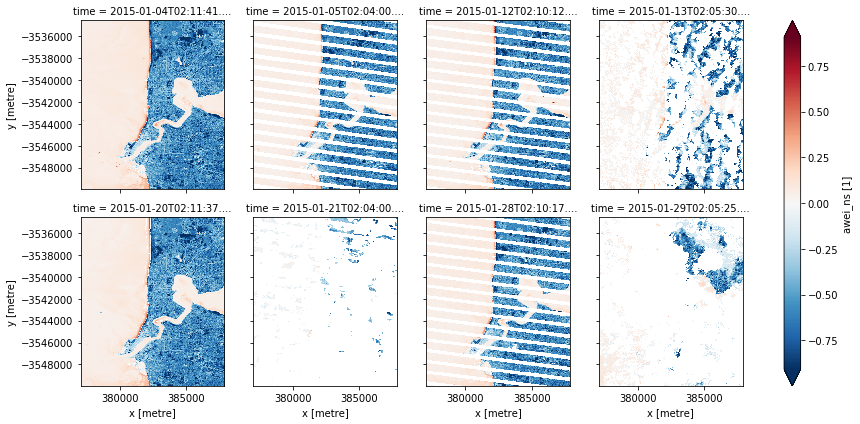

In [8]:
ds.awei_ns.isel(time=slice(0, 8)).plot.imshow(col='time', col_wrap=4, robust=True)

## Model tides

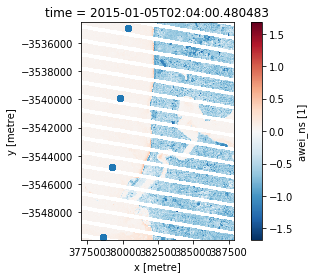

In [38]:
# Pull out subset of modelling points for region around satellite data
bounds = shapely.wkt.loads(ds.geobox.geographic_extent.buffer(0.05).wkt)
subset_gdf = points_gdf[points_gdf.geometry.intersects(bounds)]

# Extract lon, lat from tides, and time from satellite data
x_vals = subset_gdf.geometry.centroid.x
y_vals = subset_gdf.geometry.centroid.y
observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

# Create list of lat/lon/time scenarios to model
observed_timepoints = [otps.TimePoint(lon, lat, date) 
                       for date in observed_datetimes
                       for lon, lat in zip(x_vals, y_vals)]

# Model tides for each scenario
observed_predictedtides = otps.predict_tide(observed_timepoints)

# Output results into pandas.DataFrame
tidepoints_df = pd.DataFrame([(i.timepoint.timestamp, 
                               i.timepoint.lon, 
                               i.timepoint.lat, 
                               i.tide_m) for i in observed_predictedtides], 
                             columns=['time', 'lon', 'lat', 'tide_m']) 

# Convert data to spatial geopandas.GeoDataFrame
tidepoints_gdf = gpd.GeoDataFrame(data={'time': tidepoints_df.time, 
                                        'i': np.unique(tidepoints_df.time, 
                                                       return_inverse=True)[1], 
                                        'tide_m': tidepoints_df.tide_m}, 
                                  geometry=gpd.points_from_xy(tidepoints_df.lon, 
                                                              tidepoints_df.lat), 
                                  crs={'init': 'EPSG:4326'})

# Reproject to satellite data CRS
tidepoints_gdf = tidepoints_gdf.to_crs(epsg=ds.crs.epsg)

# Fix time and set to index
tidepoints_gdf['time'] = pd.to_datetime(tidepoints_gdf['time'], utc=True)
tidepoints_gdf = tidepoints_gdf.set_index('time')

# Plot a sample timestep
ds.isel(time=1).awei_ns.plot()
tidepoints_gdf.plot(ax=plt.gca())

### Interpolate tides into each satellite timestep

In [42]:
# Interpolate tides for each timestep into the spatial extent of the data
tide_da = ds.groupby('time').apply(interpolate_tide, 
                                   tidepoints_gdf=tidepoints_gdf, 
                                   sigma=20)

# Determine tide cutoff
tide_cutoff = tide_da.median(dim='time')

# Add interpolated tides as measurement in satellite dataset
ds['tide_m'] = tide_da

22.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


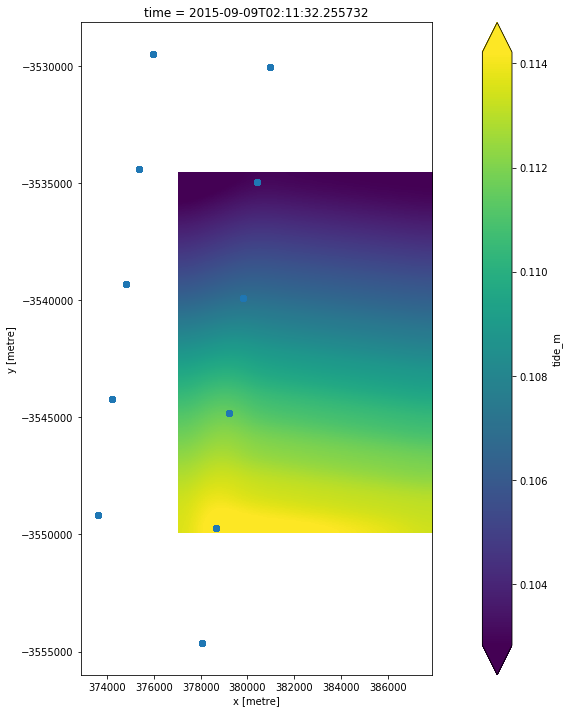

In [43]:
# Plot 
ds['tide_m'].isel(time=58).plot.imshow(robust=True, cmap='viridis', size=12)
tidepoints_gdf.plot(ax=plt.gca())

## Generate yearly composites

In [45]:
# If output folder doesn't exist, create it
output_dir = f'output_data/{name}'
os.makedirs(output_dir, exist_ok=True)

# Generate yearly high tide median water indices
yearly_ds = ds.groupby('time.year').apply(hightide_composite, 
                                          tide_cutoff=tide_cutoff, 
                                          output_dir=output_dir)


Processing 2015
Processing 2016
Processing 2017
Processing 2018


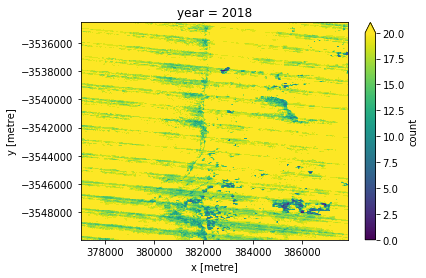

In [46]:
# Plot
yearly_ds['count'].isel(year=-1).plot(vmin=0, vmax=20)

## Extract shoreline contours

Operating in single z-value, multiple arrays mode


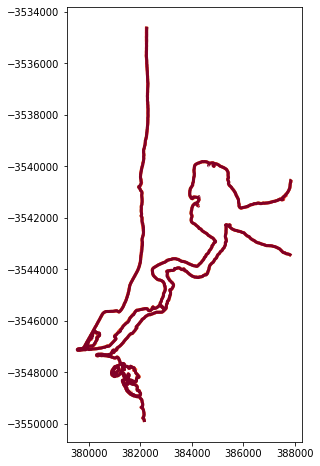

In [47]:
water_index = 'mndwi'
index_threshold = 0.0

# Apply index and threshold
thresholded_ds = yearly_ds[water_index] > index_threshold

# Drop empty timesteps
thresholded_ds = (thresholded_ds
                  .sel(year=thresholded_ds.sum(dim=['x', 'y']) > 0))

# Generate all time 600 m buffer from ocean
full_sea_mask = mask_ocean(thresholded_ds.median(dim='year'))
buffer_ocean = binary_dilation(full_sea_mask, disk(20))
buffer_land = binary_dilation(~full_sea_mask, disk(20))
sea_buffer = buffer_ocean & buffer_land

# Generate sea mask for each timestep
yearly_sea_mask = (thresholded_ds
                   .groupby('year')
                   .apply(mask_ocean))

# Keep only pixels that are within 600 m of the ocean in the
# full stack, and directly connected to ocean in each yearly timestep
masked_ds = yearly_ds[water_index].where(yearly_sea_mask & sea_buffer)

# Prepare attributes as input to contour extract
attribute_data = {'year': thresholded_ds.year.values.tolist()}  
attribute_dtypes = {'year': 'str'}

# Extract contours with custom attribute fields:
output_path = f'{output_dir}/contours_{water_index}_{index_threshold:.2f}'
contours_gdf = contour_extract(z_values=[index_threshold],
                               ds_array=masked_ds,
                               ds_crs=f'EPSG:{ds.crs.epsg}',
                               ds_affine=ds.geobox.transform,
                               output_shp=f'{output_path}.shp',
                               attribute_data=attribute_data,
                               attribute_dtypes=attribute_dtypes,
                               min_vertices=2,                                 
                               verbose=False,                                   
                               dim='year')

# Export geojson
contours_gdf.to_crs(epsg=4326).to_file(filename=f'{output_path}.geojson', 
                                       driver='GeoJSON')

# Plot
contours_gdf.plot(column='year', figsize=(12, 8), cmap='YlOrRd', linewidth=3)
# plt.gca().set_xlim(547500, 565500) 
# plt.gca().set_ylim(-3125000, -3109000)

In [ ]:
# map_shapefile(gdf=contours_gdf, hover_col='year')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)